In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif as mi
from sklearn import metrics
from pprint import pprint

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import lightgbm as gbm

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed
from numpy.random import seed

In [5]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [6]:
import plotly.express as px
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)

In [7]:
from IPython.display import display, HTML

# **Exploratory Analysis**
Let's first explore the data

In [8]:
dfs = pd.concat([train_data, test_data], ignore_index = True)
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [9]:
pp.ProfileReport(dfs)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
trace_fare = go.Histogram(x = dfs.Fare)
fig = make_subplots(rows = 2, cols = 3, vertical_spacing = 0.1, horizontal_spacing = 0.1,
                   subplot_titles = ('Fare Distribution', 'Age Distribution',
                                     'SibSp Count', 'Parch Count', 'Pclass Count',
                                    'Embarked Count'))

fig.add_trace(go.Histogram(x = dfs.Fare), row = 1, col = 1)
fig.add_trace(go.Histogram(x = dfs.Age), row = 1, col = 2)
fig.add_trace(go.Bar(x = dfs.SibSp.value_counts().index,
                     y = dfs.SibSp.value_counts()), row = 1, col = 3)
fig.add_trace(go.Bar(x = dfs.Parch.value_counts().index,
                    y = dfs.Parch.value_counts()), row = 2, col = 1)
fig.add_trace(go.Bar(x = dfs.Pclass.value_counts().index,
                    y = dfs.Pclass.value_counts()), row = 2, col =2)
fig.add_trace(go.Bar(x = dfs.Embarked.value_counts().index,
                    y = dfs.Embarked.value_counts()), row = 2, col =3)


fig.update_layout(bargap = 0.2, height = 750, showlegend = False)

Let's examine the correlation of each variable. But we need to first convert sex column into int32 and text/object datatype to dummy variable

In [11]:
#Convert Sex column into binary format
gender = {'male':1, 'female':0}
dfs.Sex = [gender[sex] for sex in dfs.Sex]

#Convert Embarked to dummy variables
def create_dummy(data, feature):
    features = []
    features.append(feature)
    data = pd.get_dummies(data, columns = features)
    return data

#Retaining Embark column
embark_holder = dfs['Embarked']
dfs = create_dummy(dfs, 'Embarked')
dfs['Embarked'] = embark_holder

In [12]:
fig = px.imshow(dfs.corr(), aspect = 'auto', origin = 'lower',
                color_continuous_scale = 'Rdbu_r')

anno = dfs.corr().values

for i, r in enumerate(anno):
    for k, j in enumerate(r):
        fig.add_annotation(x=k, y=i, text = "{:0.3f}".format(j), showarrow = False)
fig.show()

Sex and Pclass seems to have relatively high impact on Survived

# Missing Data Imputation
## Age
There are many missing data in Age variable. Let's first determine how we will go around this. It might be tempting to just fill missing age with median or mean but this is not a good idea for high variance variable or if we have a lot of missing data. In this case, we can use information from other columns to infer Age. For starter, we can use linear regression model to predict age from highly correlated variable. Also the Title of the person's name can also infer Age (eg. Master = male child = under 15)

In [13]:
dfs['Title'] = dfs.Name.str.extract('([A-Za-z]+)\.', expand = False)

Note that while there is a 'Master' title for male child, there is none for female child. So we will have to manually assign 'FemaleChild' title to those with 'Miss' title with age under 12, and for those who have age missing, we will assign it to those that has Parch > 0 and groupsize > 1

In [14]:
#Make new column of the size of people with the same ticket number
dfs['GroupSize'] = dfs.Ticket.map(dfs.Ticket.value_counts())
dfs['famsize'] = dfs['Parch'] + dfs['SibSp'] + 1

In [15]:
dfs.loc[(dfs['Title'] == 'Miss') & (dfs['Parch'] > 0) & (dfs['GroupSize'] > 1) & (dfs['Age'] <= 12), 'Title'] = 'FemaleChild'

In [16]:
dfs.loc[(dfs['Title'] == 'Miss') & (dfs['Parch'] > 0) & (dfs['GroupSize'] > 1) & (dfs['Pclass'] == 3) & (dfs.Age.isnull()), 'Title'] = 'FemaleChild'

We can use linear regression to predict Age using these correlated variable

In [17]:
dfs_td = create_dummy(dfs, 'Title')

In [18]:
model_features = ['Pclass','SibSp', 'Sex', 'Parch']
for col in dfs_td.columns:
    if 'Title' in col:
        model_features.append(col)
df_nona = dfs_td[dfs_td['Age'].notna()]
y_true = df_nona['Age']
model = LinearRegression()
model.fit(X = df_nona[model_features], y = y_true)
y_pred = model.predict(df_nona[model_features])

In [19]:
# calculate MAE, MSE, RMSE
print(metrics.mean_absolute_error(y_true, y_pred))
print(metrics.mean_squared_error(y_true, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
residuals = y_true - y_pred

8.160613647227533
111.30505360114425
10.55012102305676


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Age'>

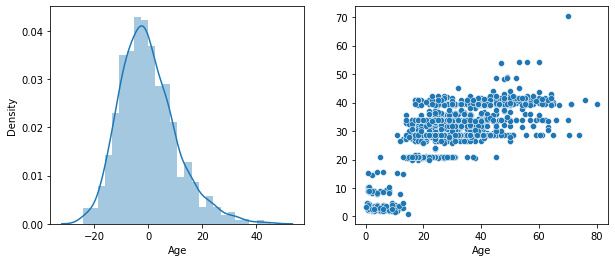

In [20]:
fig, ax = plt.subplots(1,2,figsize = (10,4))

sns.distplot(residuals, ax = ax[0])
sns.scatterplot(y_true, y_pred, ax = ax[1])

Since plotting the residuals shows a skewed normal distribution, there may be some information that we cannot capture using Regression model

In [21]:
#Store prediction
y_pred_ = model.predict(dfs_td[model_features])
dfs_td['Age_reg'] = np.round(y_pred_)

Another way we can impute Age is by grouping our data by highly correlated variable like Title and Pclass, then find the mean Age within a group to impute

In [22]:
def count_na(x):
    return len(x) - x.count()

title_agg = dfs.groupby(['Title', 'Pclass'])['Age'].agg(['mean','count', 'size', count_na]).reset_index()
title_agg

Title  Pclass       mean  count  size  count_na
0          Capt       1  70.000000      1     1         0
1           Col       1  54.000000      4     4         0
2      Countess       1  33.000000      1     1         0
3           Don       1  40.000000      1     1         0
4          Dona       1  39.000000      1     1         0
5            Dr       1  45.600000      5     6         1
6            Dr       2  38.500000      2     2         0
7   FemaleChild       1   2.000000      1     1         0
8   FemaleChild       2   5.076667     12    12         0
9   FemaleChild       3   4.609310     29    38         9
10     Jonkheer       1  38.000000      1     1         0
11         Lady       1  48.000000      1     1         0
12        Major       1  48.500000      2     2         0
13       Master       1   6.984000      5     5         0
14       Master       2   2.757273     11    11         0
15       Master       3   6.090000     37    45         8
16         Miss       1  30.827586     58    59         1
17         Miss       2  25.930556     36    38         2
18         Miss       3  22.358108     74   112        38
19         Mlle       1  24.000000      2     2         0
20          Mme       1  24.000000      1     1         0
21           Mr       1  41.450758    132   159        27
22           Mr       2  32.346715    137   150        13
23           Mr       3  28.318910    312   448       136
24          Mrs       1  43.208955     67    77        10
25          Mrs       2  33.518519     54    55         1
26          Mrs       3  32.326531     49    65        16
27           Ms       2  28.000000      1     1         0
28           Ms       3        NaN      0     1         1
29          Rev       2  41.250000      8     8         0
30          Sir       1  49.000000      1     1         0

In [23]:
title_p1 = title_agg[title_agg['Pclass'] == 1]
title_p2 = title_agg[title_agg['Pclass'] == 2]
title_p3 = title_agg[title_agg['Pclass'] == 3]

fig = go.Figure()

fig.add_trace(go.Bar(x= title_p1['Title'], y= title_p1['mean'], customdata = title_p1[['count', 'count_na']], hovertemplate = "mean = %{y:.0f}<br>count,NaN = %{customdata} ", name = 'Pclass 1'))
fig.add_trace(go.Bar(x= title_p2['Title'], y= title_p2['mean'], customdata = title_p2[['count', 'count_na']], hovertemplate = 'mean = %{y:.0f}<br>count,NaN = %{customdata}', name = 'Pclass 2'))
fig.add_trace(go.Bar(x= title_p3['Title'], y= title_p3['mean'], customdata = title_p3[['count', 'count_na']], hovertemplate = 'mean = %{y:.0f}<br>count,NaN = %{customdata}', name = 'Pclass 3'))

fig.show()

Before we impute with mean within each group, we have to make sure that there are sufficient data within each group to eastimate mean. Only Dr. from Pclass 1 and Ms. from Pclass 3 has no sufficient data to estimate mean, but  there is only 1 NaN in each so it should be fine

In [24]:
#All Age with NaN by titles and Pclass
title_agg[title_agg['count_na'] > 0]

Title  Pclass       mean  count  size  count_na
5            Dr       1  45.600000      5     6         1
9   FemaleChild       3   4.609310     29    38         9
15       Master       3   6.090000     37    45         8
16         Miss       1  30.827586     58    59         1
17         Miss       2  25.930556     36    38         2
18         Miss       3  22.358108     74   112        38
21           Mr       1  41.450758    132   159        27
22           Mr       2  32.346715    137   150        13
23           Mr       3  28.318910    312   448       136
24          Mrs       1  43.208955     67    77        10
25          Mrs       2  33.518519     54    55         1
26          Mrs       3  32.326531     49    65        16
28           Ms       3        NaN      0     1         1

In [25]:
dfs[dfs.Title == 'Dr'][['Age','Sex']]

Age  Sex
245   44.0    1
317   54.0    1
398   23.0    1
632   32.0    1
660   50.0    1
766    NaN    1
796   49.0    0
1184  53.0    1

In [26]:
dfs['Age_ME'] = dfs.groupby(['Title', 'Pclass'])['Age'].transform('mean')

In [27]:
print(metrics.mean_absolute_error(df_nona['Age'], dfs[dfs.Age.notna()]['Age_ME']))
print(metrics.mean_squared_error(df_nona['Age'], dfs[dfs.Age.notna()]['Age_ME']))
print(np.sqrt(metrics.mean_squared_error(df_nona['Age'], dfs[dfs.Age.notna()]['Age_ME'])))

7.9301935197641455
108.67582922689007
10.424769984363687


Seems like mean estimation by grouping performs better than regression. We will then manually fill the only missing Pclass 3 Ms with 26. There is a Ms in Pclass 2 with age 28. Since Pclass 2 is known to be generally older than Pclass 3, we wil just guess it is around 26.

Prediction by both methods seems to produce roughly the same result

In [28]:
dfs.at[979, 'Age_ME'] = 26
dfs['Age_reg'] = dfs_td['Age_reg']

In [29]:
#fillna in Age column with Age_ME
dfs.Age.fillna(dfs.Age_ME, inplace = True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Age_ME', ylabel='Age_reg'>

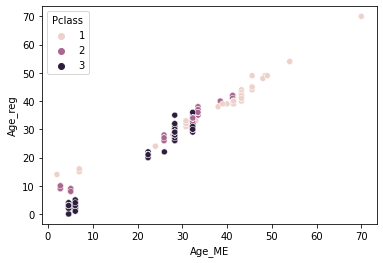

In [30]:
sns.scatterplot(dfs.Age_ME, dfs.Age_reg, hue = dfs.Pclass)

In [31]:
px.histogram(dfs, 'Age')

## Fare
Only 1 mising value in Fare. Since Fare is mostly correlated with Pclass and if the person is embarked from C

In [32]:
dfs[dfs['Ticket'] == '3701']

PassengerId  Survived  Pclass                Name  Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas    1  60.5      0   

      Parch Ticket  Fare Cabin  Embarked_C  Embarked_Q  Embarked_S Embarked  \
1043      0   3701   NaN   NaN           0           0           1        S   

     Title  GroupSize  famsize    Age_ME  Age_reg  
1043    Mr          1        1  28.31891     29.0

In [33]:
fig = go.Figure()
fig.add_trace(go.Histogram(x = dfs[dfs['Embarked_C'] == 1]['Fare'],name = 'C'))
fig.add_trace(go.Histogram(x = dfs[dfs['Embarked_Q'] == 1]['Fare'],name = 'Q'))
fig.add_trace(go.Histogram(x = dfs[dfs['Embarked_S'] == 1]['Fare'],name = 'S'))

fig.update_layout(barmode = 'overlay')
fig.update_traces(opacity = 0.4)

fig.show()

Since each embarkment place has similar Fare distribution, and this person is embarked from S, we will just fill missing value according to the mean of respective Pclass

In addition, currently Fare is a total price of a particular ticket# purchased by the whole group. To get a fare each person in the group paid, we need to divide it by the number of people purchasing that particular ticket to get fare per person 'Farepp'.

In [34]:
fare_fillna = dfs[(dfs['Pclass'] == 3) & (dfs['Sex'] == 1) & (dfs[['GroupSize', 'famsize']].max(axis=1) == 1)]['Fare'].mean()
dfs.Fare.fillna(value = fare_fillna, inplace = True)

In [35]:
dfs['Farepp'] = dfs['Fare']/dfs['GroupSize']

## Cabin
Next we will try to fill the missing Cabin data. We will first extract all cabins into groups of Deck by their front letter. Then we are going to try and analyze whether each Deck affects survival rate

In [36]:
dfs['Deck'] = dfs['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')

In [37]:
deck_agg = dfs.groupby(['Deck', 'Pclass'])[['Survived', 'Name']].agg(['count', 'sum']).reset_index()
deck_agg.drop(('Name', 'sum'), axis = 1, inplace = True)
deck_agg['relative'] = deck_agg.apply(
    lambda row: row[('Name', 'count')] / 
    deck_agg[deck_agg['Deck'] == row['Deck'].to_string().strip()][('Name', 'count')].sum(),
    axis = 1
)

def deck_index(Pclass, index):
    return deck_agg[deck_agg['Pclass'] == Pclass][index]

fig = go.Figure()
fig.add_trace(go.Bar(x=deck_index(1, 'Deck'), y= deck_index(1, 'relative'), name='Pclass 1'))
fig.add_trace(go.Bar(x=deck_index(2, 'Deck'), y= deck_index(2, 'relative'), name='Pclass 2'))
fig.add_trace(go.Bar(x=deck_index(3, 'Deck'), y= deck_index(3, 'relative'), name='Pclass 3'))

fig.update_layout(barmode = 'relative', 
                  xaxis = {'categoryorder':'array',
                          'categoryarray':['A','B','C','D','E','F','G','T','M']})
fig.show()

It would seem that each deck is highly correlated with Pclass so it will definitely have an impact on survival rate but is this information redundant since we already have Pclass variable ?

In [38]:
deck_agg['Survival_rate'] = deck_agg[('Survived', 'sum')] / deck_agg[('Survived', 'count')]

fig = go.Figure()
fig.add_trace(go.Bar(x=deck_index(1, 'Deck'), y= deck_index(1, 'Survival_rate'),
                     customdata = deck_index(1, ('Name', 'count')), name='Pclass 1',
                    hovertemplate = "Survival rate: %{y:.2f}<br>Count: %{customdata}"))
fig.add_trace(go.Bar(x=deck_index(2, 'Deck'), y= deck_index(2, 'Survival_rate'),
                     customdata = deck_index(2, ('Name', 'count')), name='Pclass 2',
                    hovertemplate = "Survival rate: %{y:.2f}<br>Count: %{customdata}"))
fig.add_trace(go.Bar(x=deck_index(3, 'Deck'), y= deck_index(3, 'Survival_rate'),
                     customdata = deck_index(3, ('Name', 'count')), name='Pclass 3',
                    hovertemplate = "Survival rate: %{y:.2f}<br>Count: %{customdata}"))

fig.update_layout(xaxis = {'categoryorder':'array',
                           'categoryarray':['A','B','C','D','E','F','G','T','M']})

fig.show()

This is a great insight. It would seem that people in deck E has very high survival rate, but not so much in Deck A. This could mean that their position within the ship can determine their survival rate. Cabin does really add extra information on survival rate, although there is so much missing data on this variiable so the data can be very noisy if there is no reliable way to predict the missing value

To make this easier we will first group each Deck together according to the proximity and sililarity in survival rate as well as Pclass composition. There will be ABC, DE, FG group and we will lump individual in cabin T to ABC group as he belongs to Pclass 1.

Those with missing value will be grouped together as M, and we will also try to subgroup the M missing deck according to their P class since there is an inherent difference in their possible deck and survival rate from Pclass.

In [39]:
deckdict = {'A':'ABC', 'B':'ABC', 'C':'ABC', 'D':'DE', 'E':'DE', 'F':'FG',
           'G':'FG', 'T':'ABC', 'M': np.NaN}
dfs['DeckGroup'] = dfs.Deck.map(deckdict)

dfs.loc[(dfs.DeckGroup == 'M') & (dfs.Pclass == 1), 'DeckGroup'] = 'M1'
dfs.loc[(dfs.DeckGroup == 'M') & (dfs.Pclass == 2), 'DeckGroup'] = 'M2'
dfs.loc[(dfs.DeckGroup == 'M') & (dfs.Pclass == 3), 'DeckGroup'] = 'M3'

To fill in missing data, we will start to see the dataset and see whether Cabin can be inferred from Ticket or Fare or by Family name

In [40]:
def displayall(data, columns, sort):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(data[columns].sort_values(sort))

def dataselect(data, columns, sort):
    return data[columns].sort_values(sort)

def displayhtml(data):
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" +
                 data.to_html() + "</div>"))
    
dfs_views = dataselect(dfs, ['Name', 'Pclass', 'DeckGroup', 'Ticket', 'Farepp', 'Embarked', 'GroupSize'],
          ['Pclass','Farepp', 'Ticket'])

displayhtml(dfs_views)

It seems like some tickets with same number can have different cabin, and Last name seems to not be unique to a family. In addition sometimes people with same Fare price can have different deck, so it will not be possible to accurately infer Cabin information from other features, but we can still infer to it to some extent. However, since there is a huge chunk of missing data it is better to leave this variable out because it would have a lot of noise

We can still try to fill it by their relative Pclass and Farepp using front propagation method. Alternatively, we can just create a new variable that indicatse whether we have information available for the Cabin

In [41]:
dfs['DeckGroup'] = dfs.sort_values(['Pclass','Farepp', 'Ticket'])['DeckGroup'].ffill()

# Feature Engineering
## Grouping variables: Title
Since there are many titles that has few people, it can introduce noise to the model. We can group some titles togehter to make it less noisy

In [42]:
px.histogram(dfs[:890], x='Title', color='Survived')

In [43]:
print('Whole Set:\n',dfs.Title.value_counts())
print('Train Set:\n',dfs[:890].Title.value_counts())
print('Test Set:\n',dfs[891:].Title.value_counts())

Whole Set:
 Mr             757
Miss           209
Mrs            197
Master          61
FemaleChild     51
Rev              8
Dr               8
Col              4
Major            2
Mlle             2
Ms               2
Lady             1
Sir              1
Mme              1
Don              1
Capt             1
Countess         1
Jonkheer         1
Dona             1
Name: Title, dtype: int64
Train Set:
 Mr             516
Miss           143
Mrs            125
Master          40
FemaleChild     39
Dr               7
Rev              6
Mlle             2
Major            2
Col              2
Countess         1
Capt             1
Ms               1
Sir              1
Lady             1
Mme              1
Don              1
Jonkheer         1
Name: Title, dtype: int64
Test Set:
 Mr             240
Mrs             72
Miss            66
Master          21
FemaleChild     12
Col              2
Rev              2
Ms               1
Dr               1
Dona             1
Name: Title, dtype: 

In [44]:
TitleDict = {'Mr':'Mr', 'Miss':'Miss', 'Mrs':'Mrs', 'Master':'Children',
            'FemaleChild':'Children', 'Dr':'Smart', 'Rev':'Mr',
             'Capt':'Smart', 'Johnkheer':'Royalty', 'Don':'Royalty',
             'Mlle':'Miss', 'Major':'Smart', 'Col':'Smart', 'Countess':'Royalty',
             'Lady':'Royalty', 'Mme':'Miss', 'Dona':'Royalty','Sir':'Royalty'
            }

dfs['Title_g'] = dfs['Title'].map(TitleDict)
dfs['Title_g'] = dfs['Title'].astype('category')

## Family Size information
We will add 'is_alone' column to indicate that the person is alone when she has no Parch or SibSp. Somebody who is alone might have a better chance at survival. We also add 'famsize' variable that adds together Parch, SibSp and him/herself. max_size will be added for which we will get the max value between Family size and Group Size (From Parch/SibSp and from Ticket#)

In [45]:
def add_isalone_column(dataset):
    dataset['is_alone'] = np.where(dataset['Parch'] + dataset['SibSp'] == 0, 1, 0)

add_isalone_column(dfs)

In [46]:
dfs['max_size'] = dfs[['GroupSize', 'famsize']].max(axis=1)

In [47]:
fig = make_subplots(rows = 1, cols = 2,
                   subplot_titles=('Survival by max_size',
                                  'max_size distribution'))

fig1 = px.histogram(dfs[0:891], x='max_size', color='Survived', barmode='group')
fig2 = px.histogram(dfs, x='max_size', color_discrete_sequence=['navy'])

def plot_px(figure, row, col):
    fig_trace = []
    for trace in range(len(figure["data"])):
        fig_trace.append(figure["data"][trace])
    for traces in fig_trace:
        fig.append_trace(traces, row=row, col=col)

plot_px(fig1, 1, 1)
plot_px(fig2, 1, 2)

fig.update_xaxes(dtick = 1)
fig.show()

## Grouping variables: max_size
We are going to label the group size by solo, duo, small, medium and large to reduce noise. Since we can capture whether the person is alone in this variable, is_alone variable won't be nneeded anymore

In [48]:
sizedict = {1:'solo', 2:'duo', 3:'small', 4:'small', 5:'medium', 6:'medium',
          7:'medium', 8:'medium', 11:'large'}

dfs['SizeLabel'] = dfs.max_size.map(sizedict)
dfs['SizeLabel'] = dfs['SizeLabel'].astype('category')

## Binning variables: Fare
Binning variables can help reduce noise and may add more information to the model. We will observe the distribution of Farepp and bin them according to the distribution wall of data

In [49]:
#Distribution of Farepp
fig = make_subplots(rows=1, cols=2)
box = px.box(dfs.Farepp)

fig.add_trace(go.Histogram(x = dfs.Farepp), row = 1, col = 1)
plot_px(box, 1, 2)

fig.show()

In [50]:
#Discretize fare value into sections according to the distribution wall of data
#Observing the walls at
#right = false
#0, 9, 13, 17, 31, 53, max of 128.0823

def binning(dataset, varname, binvar, ranges, right=False, labels=False):
    dataset[varname], bins = pd.cut(dataset[binvar], ranges, labels=labels, retbins=True,
                                   include_lowest = True, right=right)
    return bins

def add_Fareq_column(dataset, quartile):
    dataset['Fareq'], bins = pd.qcut(dataset.Farepp, quartile, labels=False, retbins=True)
    return bins

bins = binning(dfs, 'Fareq', 'Farepp', [0, 9, 13, 17, 31, 53, 129])

## Binning variables: Age
We can also bin age the same way we bin Fare

In [51]:
#Distribution of Age
fig = make_subplots(rows=1, cols=2)
box = px.box(dfs.Age)

fig.add_trace(go.Histogram(x = dfs.Age), row = 1, col = 1)
plot_px(box, 1, 2)

fig.show()

In [52]:
dfs['Age_bin'], bins = pd.qcut(dfs.Age, 10, labels=False, retbins = True)

## Information from members of the Group / Family
We need to consider the survival of people in the same group which is same family or same ticket no. If someone in the group is known to survive then the rest of the group will also be more likely to survive. We will first extract family name from the Name column, then we will try to extract more information about survivor in the same Ticket# / family.

We can extract
- FSR: Family survival rate
- TSR: Group survival rate
- FNA / TNA: Boolean whether FSR/TSR is not available
- SR: Average between FSR and TSR
- SR_NA: boolean whether there is more than 1 people in the group/family




In [53]:
dfs['Family'] = dfs.Name.str.extract(r'(.*),')

In [54]:
#Make survival rate for family group
family_group = dfs.groupby('Family')[['Survived','Name']].agg(['count', 'sum']).reset_index()
family_group.columns = [' '.join(col).strip() for col in family_group.columns.values]
family_group.columns = ['Family', 'Survived count', 'Survived sum', 'Family Size', 'drop']
family_group.drop(columns = 'drop', inplace=True)
family_group['FSR'] = family_group['Survived sum'] / family_group['Survived count']
family_group['NA_count'] = family_group['Family Size'] - family_group['Survived count']
family_group['FNA'] = (family_group['Survived count'] == 0)
family_group.loc[family_group['Family Size'] == 1, 'FNA'] = True

In [55]:
#Make survival rate for people with same Ticket number
ticket_group = dfs.groupby('Ticket')[['Survived','Family']].agg(['count', 'sum']).reset_index()
ticket_group.columns = ['Ticket', 'Survived count', 'Survived sum', 'Ticket size', 'Family']
ticket_group['TSR'] = ticket_group['Survived sum'] / ticket_group['Survived count']
ticket_group['NA_count'] = ticket_group['Ticket size'] - ticket_group['Survived count']
ticket_group['TNA'] = (ticket_group['Survived count'] == 0)
ticket_group.loc[ticket_group['Ticket size'] == 1, 'TNA'] = True

In [56]:
#Make a dict of survival rate
FSR_dict = dict(zip(family_group['Family'], family_group['FSR']))
FNA_dict = dict(zip(family_group['Family'], family_group['FNA']))
TSR_dict = dict(zip(ticket_group['Ticket'], ticket_group['TSR']))
TNA_dict = dict(zip(ticket_group['Ticket'], ticket_group['TNA']))

#Map survival rate to the main dataset
dfs['FSR'] = dfs.Family.map(FSR_dict)
dfs['FNA'] = dfs.Family.map(FNA_dict)
dfs['TSR'] = dfs.Ticket.map(TSR_dict)
dfs['TNA'] = dfs.Ticket.map(TNA_dict)

From inspecting the dataset, there are cases where either FNA / TNA is True, so we can just use the information of what is available if there are both data available, we will take average into SR variable

In [57]:
displayhtml(dataselect(dfs, ['FSR','FNA','TSR','TNA'], ['FNA', 'TNA']))

In [58]:
#Calculate SR

femalemean = dfs[dfs.Sex == 0].Survived.mean()
malemean = dfs[dfs.Sex == 1].Survived.mean()

def calculate_SR(df):
    if df.TNA == True and df.FNA == False:
        return df.FSR
    elif df.TNA == False and df.FNA == True:
        return df.TSR
    elif df.TNA == False and df.FNA == False:
        return np.mean((df.TSR, df.FSR))
    else:
        if df.Sex == 0:
            return femalemean
        else:
            return malemean

dfs['SR'] = dfs.apply(calculate_SR, axis = 1)

#Column to indicate whether our SR is NA
dfs['SR_NA'] = (dfs.TNA == True) & (dfs.FNA == True)

In [59]:
displayhtml(dataselect(dfs, ['FSR','FNA','TSR','TNA','SR', 'SR_NA'], ['FNA', 'TNA']))

From these we can make another variable 'FamilySurvived' to indicate
- -1 if no SR is available
- 0 if SR is 0
- 1 if SR is > 0 or someone survives in the same group/family

In [60]:
dfs['FamilySurvived'] = np.where(dfs['SR'] > 0, 1, 0)
dfs['FamilySurvived'] = np.where(dfs['SR_NA'] == True, -1, dfs['FamilySurvived'])

In [61]:
displayhtml(dataselect(dfs, ['SR', 'SR_NA', 'FamilySurvived'], ['SR']))

Now let's try to bin SR into categorical variable:

- 0 = No info
- 1 = 0 SR all died
- 2 = 0.1 - 0.5 SR
- 3 = 0.51 - 0.7 SR
- 4 = 0.71 - 0.99 SR
- 5 = 1 SR all survived

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='SR', ylabel='Density'>

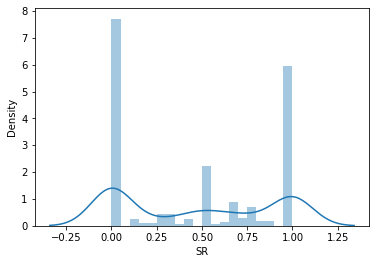

In [62]:
sns.distplot(dfs[dfs.SR_NA == False].SR, bins = 20)

In [63]:
scalar_list = [0, 0.1, 0.5, 0.7, 0.99, 1]
label = list(range(1,len(scalar_list)))

bins = binning(dfs, 'SR_cat', 'SR', scalar_list, labels = [str(i) for i in label],
               right=True)
dfs['SR_cat'] = dfs['SR_cat'].astype('category')
dfs['SR_cat'] = dfs['SR_cat'].cat.add_categories('0')
dfs['SR_cat'] = dfs['SR_cat'].cat.reorder_categories([str(i) for i in range(len(scalar_list))],
                                                     ordered = True)
dfs.loc[dfs.SR_NA == True, 'SR_cat'] = '0'

In [64]:
displayhtml(dataselect(dfs, ['SR', 'SR_cat', 'SR_NA'], ['SR_cat', 'SR']))

In [65]:
displayhtml(dataselect(dfs, ['SR', 'SR_cat'], ['SR_cat', 'SR']))

In [66]:
train_data = dfs[0:891]
px.histogram(train_data, x='SR_cat', color='Survived', barmode = 'group',
            category_orders=dict(SR_cat=[str(i) for i in range(len(scalar_list))]))

# Prediction
## Creating dummy variables
We will choose all engineered and/or highly correlated features into the model. We need to convert categorical or object variable into dummy variables first before we feed it into a model


In [67]:
#Choosing features in a model
features = ["Pclass","Sex","SizeLabel","Age_bin","Title_g",'Fareq','FamilySurvived']
dfs_data = dfs[features]
dfs_dummy = pd.get_dummies(dfs_data)

#RF
X = dfs_dummy[0:891]
X_test = dfs_dummy[891:]

#NN
train_data = dfs[0:891]
test_data = dfs[891:]

#target
y = train_data["Survived"]

In [68]:
#Checking NaN value in Train and Test dataset
for name, data in {'Training Data':train_data, 'Test Data':test_data}.items():
    print(f'For {name}:')
    for col in data.columns:
        print(f"{col} has {data[col].isna().sum()} NaN")
    print()

For Training Data:
PassengerId has 0 NaN
Survived has 0 NaN
Pclass has 0 NaN
Name has 0 NaN
Sex has 0 NaN
Age has 0 NaN
SibSp has 0 NaN
Parch has 0 NaN
Ticket has 0 NaN
Fare has 0 NaN
Cabin has 687 NaN
Embarked_C has 0 NaN
Embarked_Q has 0 NaN
Embarked_S has 0 NaN
Embarked has 2 NaN
Title has 0 NaN
GroupSize has 0 NaN
famsize has 0 NaN
Age_ME has 0 NaN
Age_reg has 0 NaN
Farepp has 0 NaN
Deck has 0 NaN
DeckGroup has 0 NaN
Title_g has 0 NaN
is_alone has 0 NaN
max_size has 0 NaN
SizeLabel has 0 NaN
Fareq has 0 NaN
Age_bin has 0 NaN
Family has 0 NaN
FSR has 0 NaN
FNA has 0 NaN
TSR has 0 NaN
TNA has 0 NaN
SR has 0 NaN
SR_NA has 0 NaN
FamilySurvived has 0 NaN
SR_cat has 0 NaN

For Test Data:
PassengerId has 0 NaN
Survived has 418 NaN
Pclass has 0 NaN
Name has 0 NaN
Sex has 0 NaN
Age has 0 NaN
SibSp has 0 NaN
Parch has 0 NaN
Ticket has 0 NaN
Fare has 0 NaN
Cabin has 327 NaN
Embarked_C has 0 NaN
Embarked_Q has 0 NaN
Embarked_S has 0 NaN
Embarked has 0 NaN
Title has 0 NaN
GroupSize has 0 NaN
fa

## RandomForest Model
We will use simple random forest model as a baseline for our prediction

In [69]:
#Baseline model as initially given
RF_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
RF_baseline = RF_model.fit(X, y)
predictions = RF_baseline.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype(int)})
output.to_csv('RF_baseline.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Next, we will tune this model using GridSearchCV and we will tune from the most important features first to the least:
- max_depth and min_samples_split
- min_samples_leaf and max_samples

Prediction scores should improved in each tuning.

In [70]:
#Tuning Hyperparameter of Random Forest Classifier
pprint(RF_model.get_params())

#Tuning function
def tune(model, param):
    gsearch = GridSearchCV(estimator = model, param_grid = param,
                             scoring = 'roc_auc', n_jobs = -1, cv = 4)
    gsearch.fit(X, y)
    print (gsearch.best_params_, gsearch.best_score_)
    model.set_params(**gsearch.best_params_)
    return gsearch

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [71]:
#Tune max_depth and min_samples_split
param_grid = {'max_depth':range(3,15),
             'min_samples_split':range(2,10)}
RF_tuned = RF_model
gsearch = tune(RF_tuned,param_grid)

{'max_depth': 7, 'min_samples_split': 5} 0.9154575003006449


In [72]:
#Tune min_samples_leaf and max_samples
param_grid = {'min_samples_leaf': range(1,8),
             'max_samples':[i / 100 for i in range(70,100,5)]}
gsearch = tune(RF_tuned,param_grid)

{'max_samples': 0.8, 'min_samples_leaf': 1} 0.9147305652719488


In [73]:
#n_estimators
param_grid = {'n_estimators':range(100,2001,200)}
gsearch = tune(RF_tuned,param_grid)

{'n_estimators': 700} 0.9154754377007827


In [74]:
#Print param of tuned RF
pprint(RF_tuned.get_params())

#Prediction from Tuned RF
predictions = RF_tuned.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype(int)})
output.to_csv('RF_tuned.csv', index=False)
print("Your submission was successfully saved!")

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 700,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
Your submission was successfully saved!


# XGBoost Classifier
XGBoost is a more complex tree based classifier
We will try to use this more complex model and tune it the same way as we did earlier for RF, from the most impactful parameter to the least. We will first have to find an optimal number of tree for high learning rate so that we can tune these parameters quickly. We will tune regularization parameter last before we decrease learning rate and increase trees.

In [75]:

xgb_model = xgb.XGBClassifier(learning_rate = 0.01, random_state=1)
xgb_baseline = xgb_model.fit(X, y)
predictions = xgb_baseline.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype(int)})
output.to_csv('XGB_baseline.csv', index=False)
print("Your XGBbaseline model was successfully saved!")


[16:25:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Your XGBbaseline model was successfully saved!


In [76]:

xgb1 = XGBClassifier(learning_rate = 0.1,
max_depth = 5,
min_child_weight = 1,
gamma = 0,
subsample = 0.8,
colsample_bytree = 0.8,
objective = 'binary:logistic',
scale_pos_weight = 1,
use_label_encoder = False,
seed = 63)

#Set high LR and using CV to find optimal number of trees
xgb_param = xgb1.get_xgb_params()
xgbtrain = xgb.DMatrix(X, label = y, enable_categorical = True)
cv_result = xgb.cv(xgb_param, xgbtrain, num_boost_round = 1000, metrics = 'auc', 
       early_stopping_rounds = 50)

xgb1.set_params(n_estimators = cv_result.shape[0])


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=16, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=1, seed=63, subsample=0.8,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)

In [77]:

#Tune max_depth and min_child weight
param_grid = {'max_depth':range(9, 12, 1) , 'min_child_weight':range(1,3,1)}
gsearch = tune(xgb1, param_grid)


[16:25:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'max_depth': 9, 'min_child_weight': 1} 0.9295096154305345


In [78]:

#Tune Gamma
param_grid = {'gamma':[i / 10 for i in range(0,5)]}
gsearch = tune(xgb1, param_grid)


[16:26:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'gamma': 0.0} 0.9295096154305345


In [79]:

#Tune subsample and colsample_bytree
param_grid = {'subsample':[i/10 for i in range(6,10)],
              'colsample_bytree':[i/10 for i in range(6,10)]}
gsearch = tune(xgb1, param_grid)


[16:29:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 0.8, 'subsample': 0.8} 0.9295096154305345


In [80]:

#Further tuning subsample and colsample_bytree around previous best params
param_grid = {'subsample':[i/100 for i in range(80,96,5)],
              'colsample_bytree':[i/100 for i in range(80,96,5)]}
gsearch = tune(xgb1, param_grid)


[16:25:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [81]:

#Tuning Regularization Parameters
param_grid = {'reg_alpha':[0.01, 0.1],
              'reg_lambda':[1.3]}
gsearch = tune(xgb1, param_grid)
#alpha = 0.0001, lambda = 1 best, not needed


[16:31:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'reg_alpha': 0.01, 'reg_lambda': 1.3} 0.9301632560281314


In [82]:

#Decreasing learning rate and increase trees
xgb_param = xgb1.get_xgb_params()
xgb_param['learning_rate'] = 0.001
cv_result = xgb.cv(xgb_param, xgbtrain, num_boost_round = 10000, metrics = 'auc', 
       early_stopping_rounds = 1500)


In [83]:

#So far, max depth = 9, minchildweight = 1, gamma = 0, colsample and subsample = 0.8
#reg_lambda = 0.4, reg_alpha = 0.01, LR = 0.001, n_estimators = 3014
xgb1.set_params(max_depth = 9, min_child_weight = 1, gamma = 0, reg_lambda = 1.3,
                reg_alpha = 0.01,
               colsample_bytree = 0.85, subsample = 0.85, learning_rate = 0.001,
               n_estimators = 2520)


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.85,
              enable_categorical=False, gamma=0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_delta_step=None, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=2520, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=0.01, reg_lambda=1.3,
              scale_pos_weight=1, seed=63, subsample=0.85, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)

In [84]:

#Set learning rate and boosting number
xgb1.set_params(learning_rate = 0.001, n_estimators = cv_result.shape[0])


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.85,
              enable_categorical=False, gamma=0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_delta_step=None, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=2520, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=0.01, reg_lambda=1.3,
              scale_pos_weight=1, seed=63, subsample=0.85, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)

In [85]:

#Fit the model and predict
xgb1.fit(X, y)
predictions = xgb1.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('XGBoost_tuned.csv', index=False)
print("Your XGBoost model was successfully saved!")


[16:33:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Your XGBoost model was successfully saved!


## Neural Network
We will try to use simple neural network model to predict.
We set a high number of nodes since, having high nodes doesn't impact the model negatively in terms of prediction

We need to split train/test from the train data, since there are only 891 data points on train set. Data is splitted into 70%-TRAIN 30%VALIDATION set.
Dev set is not neccessary as we can use the real test set as test set.
We will also shuffle our dataset before the split.

In [86]:
def nn_model():
    model = keras.Sequential([
        layers.Dense(100, activation = 'LeakyReLU'),
        layers.Dense(100, activation = 'LeakyReLU'),
        layers.Dense(50, activation = 'LeakyReLU'),
        layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
    return model

In [87]:
s_data = train_data.sample(frac=1, random_state = 0)

In [88]:
#Then we will get our features and label from our data and convert into tensor
def extract(dataset, features, test=False):
    X = pd.get_dummies(dataset[features])
    if test == False:
        y = dataset["Survived"]
        return X, y
    if test == True:
        return X

def make_train_test_set(split):
    split = int(split * len(s_data))
    training_set = s_data[:split]
    val_set = s_data[split:]

    train_X, train_y = extract(training_set, features)
    test_X, test_y = extract(val_set, features)
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = make_train_test_set(0.7)


In [89]:
seed(6)
set_seed(6)

#Now we fit the model
nn_model1 = nn_model()
nn_model1.fit(train_X, train_y, epochs = 50, batch_size = 16)
nn_model1.evaluate(test_X, test_y)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/50
39/39 [==============================] - 1s 2ms/step - loss: 0.5216 - accuracy: 0.7512
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.8138
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3996 - accuracy: 0.8379
Epoch 4/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3881 - accuracy: 0.8555
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3828 - accuracy: 0.8427
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3816 - accuracy: 0.8539
Epoch 7/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3576 - accuracy: 0.8604
Epoch 8/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3611 - accuracy: 0.8604
Epoch 9/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3485 - accuracy: 0.8620
Epoch 10/50
39/39 [==============================] - 0s 2ms/step - loss: 0.3366 - accuracy: 0.8587
Epoch 11/50
39/39 [

[0.4332835376262665, 0.8656716346740723]

In [90]:

prediction = nn_model1.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction.flatten()})
output['Survived'] = output['Survived'] > 0.5
output['Survived'] = output['Survived'].astype(int)
output.to_csv('NN_model.csv', index=False)
print("Your NN_model model was successfully saved!")


Your NN_model model was successfully saved!


## LGBM
Another tree-based model but less complex and faster than XGBoost

In [91]:
gmb_model = gbm.LGBMClassifier(learning_rate = 0.1, random_state=1)

lgbm_model = gmb_model.fit(X, y)
predictions = lgbm_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype(int)})
output.to_csv('LGBM.csv', index=False)
print("Your LGBM model was successfully saved!")

'''#Cross Validating using different learning rate for the model
def cross_validation(model, X, y, folds):
    cv_results = cross_validate(model, X, y, cv = folds)
    return cv_results['test_score']
X_cross = pd.get_dummies(train_data[features])
y_cross = train_data["Survived"]
learning_rate = [0.09, 0.1, 0.15]
for lr in learning_rate:
    tuning_model = gbm.LGBMClassifier(learning_rate = lr, random_state=1, use_label_encoder = False)
    scoring = np.mean(cross_validation(tuning_model, X, y_cross, 3))
    print(str(lr)+str(scoring))'''

Your LGBM model was successfully saved!


'#Cross Validating using different learning rate for the model\ndef cross_validation(model, X, y, folds):\n    cv_results = cross_validate(model, X, y, cv = folds)\n    return cv_results[\'test_score\']\nX_cross = pd.get_dummies(train_data[features])\ny_cross = train_data["Survived"]\nlearning_rate = [0.09, 0.1, 0.15]\nfor lr in learning_rate:\n    tuning_model = gbm.LGBMClassifier(learning_rate = lr, random_state=1, use_label_encoder = False)\n    scoring = np.mean(cross_validation(tuning_model, X, y_cross, 3))\n    print(str(lr)+str(scoring))'

# Feature Importance
## PIMP Algorithm
We can decide which features is good for the model and which isn't using PIMP algorithm. This algorithm shuffle the target value in each iteration of predictions to get a distribution of importance (GINI and Mutual Information) which we can see where our real target value lie in the distribution. We are using fast model like RandomForest Classifier for predictions

In [92]:
#PIMP Algorithm to choose features
def get_feature_importance(X, y, shuffle = True):
    if shuffle == True:
        y = y.copy().sample(frac=1)
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
    perm_model = model.fit(X, y)
    
    imp_df = pd.DataFrame()
    imp_df['features'] = X.columns
    imp_df['importance_split'] = perm_model.feature_importances_
    imp_df['importance_gain'] = mi(X, y)
    imp_df['training_score'] = perm_model.score(X, y)
    
    return imp_df

In [93]:
#Creating Null Importance
def make_null_imp(X, y, runs):
    null_imp_df = pd.DataFrame()

    import time
    start = time.time()

    for i in range(runs):
        #Get current importance
        imp_df = get_feature_importance(X, y)
        imp_df['run'] = i+1
        #Concat current imp_df to null_imp_df
        null_imp_df = pd.concat([null_imp_df, imp_df], axis = 0)
        #Display current runtime and time used
        spent = (time.time() - start) / 60
        print(f'done with {i+1} of {runs} (spent {spent} min) ')
        
    return null_imp_df

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

def display_histogram(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['features'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['features'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['features'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['features'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

In [94]:
actual_imp_df = get_feature_importance(X, y, shuffle = False)
null_imp_df = make_null_imp(X, y, 50)

done with 1 of 50 (spent 0.006783727804819743 min) 
done with 2 of 50 (spent 0.01367793083190918 min) 
done with 3 of 50 (spent 0.020631428559621176 min) 
done with 4 of 50 (spent 0.02741676171620687 min) 
done with 5 of 50 (spent 0.03437085151672363 min) 
done with 6 of 50 (spent 0.041305009524027506 min) 
done with 7 of 50 (spent 0.048264706134796144 min) 
done with 8 of 50 (spent 0.05582913557688395 min) 
done with 9 of 50 (spent 0.0629208246866862 min) 
done with 10 of 50 (spent 0.06993581851323445 min) 
done with 11 of 50 (spent 0.07709090312321981 min) 
done with 12 of 50 (spent 0.08416620492935181 min) 
done with 13 of 50 (spent 0.0911732832590739 min) 
done with 14 of 50 (spent 0.09824302196502685 min) 
done with 15 of 50 (spent 0.10514246225357056 min) 
done with 16 of 50 (spent 0.11224610408147176 min) 
done with 17 of 50 (spent 0.1197355310122172 min) 
done with 18 of 50 (spent 0.1266656796137492 min) 
done with 19 of 50 (spent 0.13370262781778972 min) 
done with 20 of 50 (s

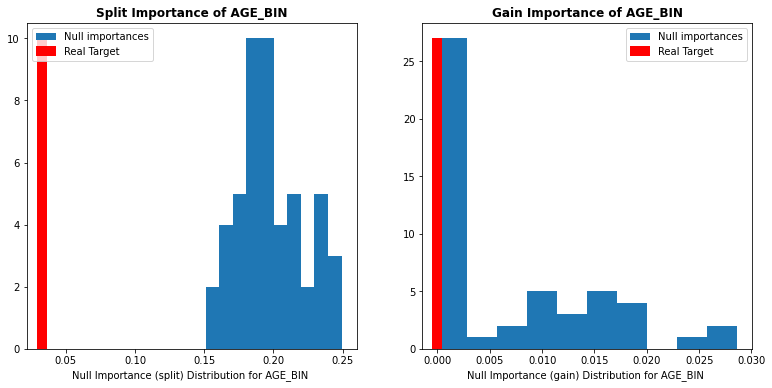

In [100]:
def get_importance(feature):  
    display_histogram(actual_imp_df, null_imp_df, feature)
    
get_importance('Age_bin')